# k-means

The $k$-means algorithm is one of the best-known and most widely used clustering methods, although it has some serious limitations and drawbacks. 

Given a sample matrix $\bfX$ with $n$ rows $\bfx_i$, the algorithm divides the sample points into disjoint sets $C_1,\ldots,C_k$, where $k$ is a preselected hyperparameter. Cluster $j$ has a **centroid** $\bfmu_j$, which is the mean of the points in $C_j$. Define the **inertia** of $C_j$ as 

$$
I_j = \sum_{\bfx\in C_j} \norm{ \bfx - \bfmu_j }_2^2.
$$

The goal of the algorithm is to choose the clusters in order to minimize the total inertia,

$$
I = \sum_{j=1}^k I_j.
$$

<!-- For any cluster, its centroid is the point that minimizes the inertia of the cluster. Suppose that $C_j$ is split into two parts $A$ and $B$ that have centroids $\bfmu_A$ and $\bfmu_B$. Those centroids minimize the inertias of the subclusters. Hence, 

$$
\sum_{\bfx\in A} \norm{ \bfx - \bfmu_A }^2 + \sum_{\bfx\in B} \norm{ \bfx - \bfmu_B }^2 
\le  \sum_{\bfx\in A} \norm{ \bfx - \bfmu_j }^2 + \sum_{\bfx\in B} \norm{ \bfx - \bfmu_j}^2  = I_j. 
$$

We conclude that splitting a cluster will make the total inertia decrease. In fact, if each sample point is put into its own cluster, the inertia is 0.  -->

::::{prf:example}
:label: example-k-means-inertia
Let $k=2$. Given the values $-3,-2,-1,2,5,7$, we might cluster $\{-3,-2,-1\}$ and $\{2,5,7\}$. The total inertia is then

$$
\left[  (-3+2)^2 + (-2+2)^2 + (-1+2)^2   \right]  + \left[  \bigl(2-\tfrac{14}{3}\bigr)^2 + \bigl(5-\tfrac{14}{3}\bigr)^2 + \bigl(7-\tfrac{14}{3}\bigr)^2   \right] = 2 + \frac{124}{9} = 15.78.
$$

If we instead cluster as $\{-3,-2,-1,2\}$ and $\{5,7\}$, then the total inertia is 

$$
\left[  (-3+1)^2 + (-2+1)^2 + (-1+1)^2  + (2+1)^2 \right]  + \left[   (5-6)^2 + (7-6)^2   \right] = 14 + 2 = 16.
$$
::::

Finding the minimum inertia among all possible $k$-clusterings is an infeasible problem to solve exactly at any practical size. Instead, the approach is to iteratively improve from a starting clustering.

## Lloyd's algorithm

The standard method is known as **Lloyd's algorithm**. Starting with values for the $k$ centroids, there is an iteration consisting of two steps:

* **Assignment** Each sample point is assigned to the cluster whose centroid is the nearest. (Ties are broken randomly.)
* **Update** Recalculate the centroids based on the cluster assignments:

$$
\bfmu_j^+ = \frac{1}{|C_j|} \sum_{\bfx\in C_j} \bfx.
$$

The algorithm stops when the assignment step does not change any of the clusters. In practice, this almost always happens quickly. Here is a demonstration:

```{raw} html
<video width=640 controls src="../_static/kmeans_demo.mp4"></video>
```

While Lloyd's algorithm will find a local minimum of total inertia, in the sense that small changes cannot decrease it, there is no guarantee of converging to the global minimum.

## Practical issues

* **Initialization**. The performance of $k$-means depends a great deal on the initial set of centroids. Traditionally, the centroids were chosen as random members of the sample set, but better/more reliable heuristics, such as *$k$-means++*, have since become more dominant. 
* **Multiple runs**. All the initialization methods include an element of randomness, and since the Lloyd algorithm usually converges quickly, it is often run with multiple instances of the initialization, and the run with the lowest inertia is kept.
* **Selection of $k$**. The algorithm treats $k$ as a hyperparameter. Occam's Razor dictates preferring smaller values to large ones. There are many suggestions on how to find the choice that gives the most "bang for the buck."
* **Distance metric**. The Lloyd algorithm often fails to converge for norms other than the 2-norm, and must be modified if another norm is preferred.
* **Shape effects**. Because of the dependence on the norm, the inertia criterion disfavors long, skinny clusters and clusters of unequal dispersion. Basically, it wants to find spherical blobs (as defined by the metric) of roughly equal size.

## Toy example

Let's generate some test blobs.

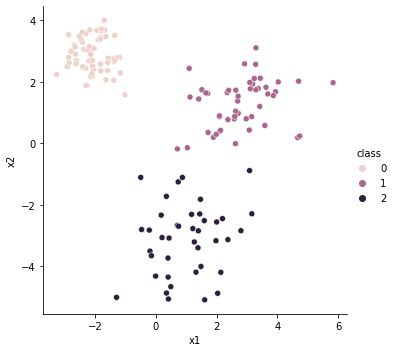

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_blobs
X,y = make_blobs(
    n_samples=[60,50,40],
    centers=[[-2,3],[3,1.5],[1,-3]],
    cluster_std=[0.5,0.9,1.2],
    random_state = 19716
    )
blobs = pd.DataFrame({"x1":X[:,0],"x2":X[:,1],"class":y})
sns.relplot(data=blobs,x="x1",y="x2",hue="class");

We start $k$-means with $k=2$ clusters, not presupposing prior knowledge of how the samples were created.

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score

km2 = KMeans(n_clusters=2)
km2.fit(X)

KMeans(n_clusters=2)

The fitted clustering object can tell how many iterations were required, and what the final inertia and cluster centroids are:

In [3]:
print("k=2 took",km2.n_iter_,"iterations")
print("\nfinal inertia:",km2.inertia_)
print("\ncluster centroids:")
print(km2.cluster_centers_)

k=2 took 3 iterations

final inertia: 710.0834960683221

cluster centroids:
[[-2.01977462  2.86247767]
 [ 2.01902057 -0.69722874]]


Every type of clustering object has a `labels_` property that is a list of cluster index values, indicating the cluster membership of each sample.

In [4]:
print("cluster assignments:")
blobs["km2"] = km2.labels_
print(blobs["km2"])

cluster assignments:
0      1
1      1
2      1
3      0
4      1
      ..
145    0
146    1
147    0
148    0
149    1
Name: km2, Length: 150, dtype: int32


There is also a `predict` method that can make cluster assignments for arbitrary points in feature space. In k-means, this just tells you which centroid is closest.

In [5]:
km2.predict([ [-2,-1],[1,2] ])

array([0, 1], dtype=int32)

Next, we calculate the silhouettes for the samples and plot the blobs using color to show cluster membership and dot size to indicate the silhouette value.

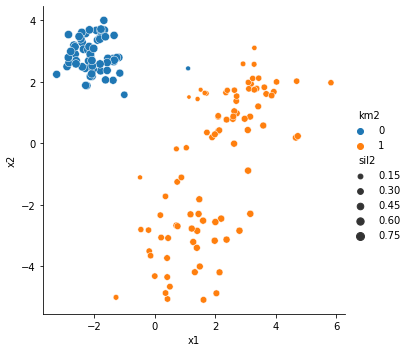

In [6]:
blobs["sil2"] = silhouette_samples(X,blobs["km2"])
sns.relplot(data=blobs,x="x1",y="x2",hue="km2",size=blobs["sil2"]);

Here is a summary of the silhouettes:

In [7]:
print("overall silhouette score:",blobs["sil2"].mean())
blobs.groupby("km2")["sil2"].describe()

overall silhouette score: 0.5876658515793556


,count,mean,std,min,25%,50%,75%,max
km2,,,,,,,,
0,61.0,0.821274,0.097362,0.148612,0.819975,0.839082,0.856779,0.878424
1,89.0,0.427552,0.101098,0.068622,0.392936,0.440536,0.500103,0.559821


It's intuitively clear that cluster 0 is more tightly packed than cluster 1, and that comparison is borne out by the silhouettes.

Next, we repeat the computation for $k=3$ clusters.

In [8]:
km3 = KMeans(n_clusters=3)
km3.fit(X)
print("inertia for k=3:",km3.inertia_)

blobs["km3"] = km3.labels_
blobs["sil3"] = silhouette_samples(X,blobs["km3"])
print("\noverall silhouette score:",blobs["sil3"].mean())
print("\nsilhouette statistics:")
blobs.groupby("km3")["sil3"].describe()

inertia for k=3: 203.30412157574375

overall silhouette score: 0.6998700192151341

silhouette statistics:


,count,mean,std,min,25%,50%,75%,max
km3,,,,,,,,
0,60.0,0.815912,0.051718,0.550642,0.795554,0.828146,0.847986,0.869913
1,39.0,0.608026,0.126090,0.252421,0.583289,0.645840,0.692839,0.724903
2,51.0,0.633584,0.147521,0.143121,0.554019,0.688014,0.738117,0.765192


Here we show the points using color to indicate cluster membership and size for the silhouette value:

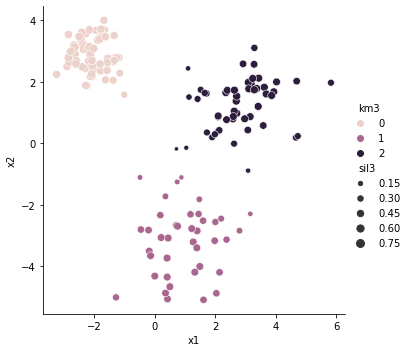

In [9]:
blobs["sil3"] = silhouette_samples(X,blobs["km3"])
sns.relplot(data=blobs,x="x1",y="x2",hue="km3",size=blobs["sil3"]);

Intuitively, this is at least comparable to the original classification. The silhouettes show a modest reduction for the better clusters, but improvement for the problematic one.

In [10]:
km4 = KMeans(n_clusters=4)
km4.fit(X)
print("inertia for k=4:",km4.inertia_)

blobs["km4"] = km4.labels_
blobs["sil4"] = silhouette_samples(X,blobs["km4"])
print("\noverall silhouette score:",blobs["sil4"].mean())
print("\nsilhouette statistics:")
blobs.groupby("km4")["sil4"].describe()

inertia for k=4: 164.391814996702

overall silhouette score: 0.595999447128127

silhouette statistics:


,count,mean,std,min,25%,50%,75%,max
km4,,,,,,,,
0,21.0,0.418371,0.126162,0.082891,0.351500,0.445146,0.528694,0.568619
1,60.0,0.795515,0.061484,0.469210,0.772766,0.811955,0.831872,0.856250
2,39.0,0.552206,0.159800,0.053503,0.534857,0.608952,0.659587,0.692206
3,30.0,0.378241,0.159276,0.046288,0.235643,0.430824,0.511360,0.559574


The outlier points in the generated blobs are perhaps best seen as noisy examples, at least for the purposes of clustering. 

## Case study: digits

We can return to the handwriting recognition dataset. Again we keep only the samples labeled 4, 5, or 6.

In [11]:
from sklearn import datasets
digits = datasets.load_digits(as_frame=True)["frame"]
keep = digits["target"].isin([4,5,6])
digits = digits[keep]

X = digits.drop("target",axis="columns")
y = digits["target"]

We fit 3 clusters to the feature matrix:

In [12]:
km = KMeans(n_clusters=3)
km.fit(X)
digits["kmeans3"] = km.labels_
digits[["target","kmeans3"]].head(9)

,target,kmeans3
4,4,0
5,5,2
6,6,1
14,4,0
15,5,2
16,6,1
24,4,0
25,5,2
26,6,1


The adjusted Rand index suggests that we have reproduced the classification very well:

In [13]:
from sklearn.metrics import adjusted_rand_score
ARI = adjusted_rand_score(y,digits["kmeans3"])
print("ARI:",ARI)

ARI: 0.9617847446531459


However, that conclusion benefits from our prior knowledge. What if we did not know how many clusters to look for? Let's look over a range of $k$ values, recording the final total inertia and the mean silhouette score for each

In [14]:
results = []
for k in range(2,8):
    km = KMeans(n_clusters=k,random_state=0)
    km.fit(X)

    I = km.inertia_
    sil = silhouette_score(X,km.labels_)
    results.append([k,I,sil])

pd.DataFrame(results,columns=["k","inertia","mean silhouette"])

,k,inertia,mean silhouette
0,2,446601.467620,0.226800
1,3,360547.755566,0.251904
2,4,325232.684483,0.245855
3,5,297525.087772,0.235199
4,6,280632.563349,0.188324
5,7,270388.673287,0.170556


The inertia continues to decrease as $k$ increases, although the rate of decrease slows somewhat. The silhouette score is maximized at $k=3$, which could be considered a reason to choose 3 clusters, although the difference between 3 and 4 clusters is not large.

<div style="max-width:400px"><div style="position:relative;padding-bottom:71.25%"><iframe id="kaltura_player" src="https://cdnapisec.kaltura.com/p/2358381/sp/235838100/embedIframeJs/uiconf_id/43030021/partner_id/2358381?iframeembed=true&playerId=kaltura_player&entry_id=1_8qjp92ut&flashvars[streamerType]=auto&amp;flashvars[localizationCode]=en&amp;flashvars[leadWithHTML5]=true&amp;flashvars[sideBarContainer.plugin]=true&amp;flashvars[sideBarContainer.position]=left&amp;flashvars[sideBarContainer.clickToClose]=true&amp;flashvars[chapters.plugin]=true&amp;flashvars[chapters.layout]=vertical&amp;flashvars[chapters.thumbnailRotator]=false&amp;flashvars[streamSelector.plugin]=true&amp;flashvars[EmbedPlayer.SpinnerTarget]=videoHolder&amp;flashvars[dualScreen.plugin]=true&amp;flashvars[Kaltura.addCrossoriginToIframe]=true&amp;&wid=1_h4xcxibr" width="400" height="285" allowfullscreen webkitallowfullscreen mozAllowFullScreen allow="autoplay *; fullscreen *; encrypted-media *" sandbox="allow-forms allow-same-origin allow-scripts allow-top-navigation allow-pointer-lock allow-popups allow-modals allow-orientation-lock allow-popups-to-escape-sandbox allow-presentation allow-top-navigation-by-user-activation" frameborder="0" title="Kaltura Player" style="position:absolute;top:0;left:0;width:100%;height:100%"></iframe></div></div>